# Prudential Life Insurance Assessment
    Created By :
    - Alvaro Amos H.
    - Reynold Vinson Chen
    - Winly Williamdy        

In [1]:
#Importing Library
%matplotlib inline
import numpy as np
import dash
import dash_core_components as dcc
import dash_html_components as html
import scipy as sp
from scipy.special import erfinv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Setup table visualization
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("darkgrid")
sns.set_context("poster")
pd.set_option('display.max_rows', None)

# Used for normalizing data later on

In [3]:
def to_gauss(x): return np.sqrt(2)*erfinv(x)  #from scipy

def normalize(data, exclude=None):
    # if not binary, normalize it
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()# list of sorted index
        uniform = np.linspace(start=-0.99, stop=0.99, num=n) # linsapce
        normal = to_gauss(uniform) # apply gauss to linspace
        normalized_col = pd.Series(index=sorted_idx, data=normal) # sorted idx and normalized space
        data[col] = normalized_col # column receives its corresponding rank
    return data

# Loading train data

In [4]:
train=pd.read_csv("../data/train.csv")
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,...,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


There are around 128 features (boundary conditions) and on a very broad level, these can be categorized into:

1. Product Information 
2. Age
3. Height
4. Weight
5. BMI
6. Employment Information
7. Other insured information
8. Family History
9. Medical History
10. Medical Keywords

The following variables are all categorical (nominal):

Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41

The following variables are continuous:

Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5

The following variables are discrete:

Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32

Medical_Keyword_1-48 are dummy variables.

In [5]:
#Isolating the Id and Response columns for future need
train_id = train['Id']
train_response = train['Response']

There are 18 unique variables in Product_Info_2

In [6]:
train.Product_Info_2.unique()

array(['D3', 'A1', 'E1', 'D4', 'D2', 'A8', 'A2', 'D1', 'A7', 'A6', 'A3',
       'A5', 'C4', 'C1', 'B2', 'C3', 'C2', 'A4', 'B1'], dtype=object)

In [7]:
train_response.value_counts()

8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

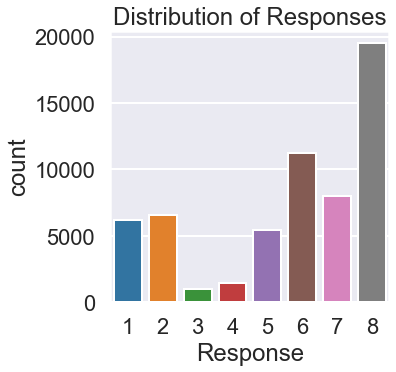

In [8]:
sns.set_color_codes()
plt.figure(figsize=(5,5))
sns.countplot(train_response).set_title('Distribution of Responses')

We can see that Class 8 has the highest distribution. As such, we will assume that this is the most basic type of insurance policies. We will make this our default go-to policy. This is basically to convert the multiclass property of this problem into a binary problem.

Let's first plot a few variables. These will be helpful in doing some very important feature engineering.

# Variable Plotting

## BMI

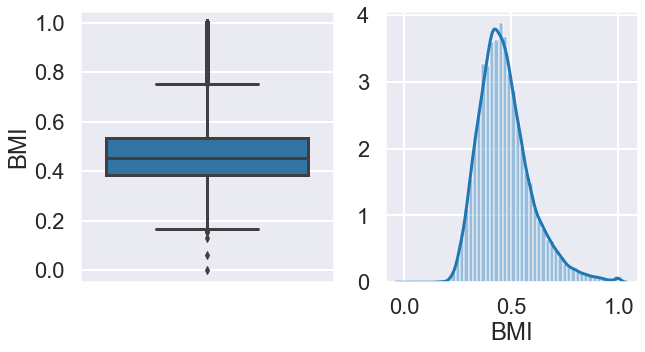

In [9]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'BMI', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['BMI'],  ax=axes[1])

## Age

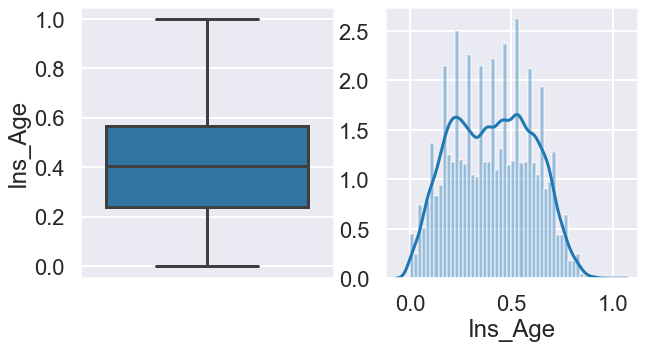

In [10]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'Ins_Age', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['Ins_Age'],  ax=axes[1])

## Height

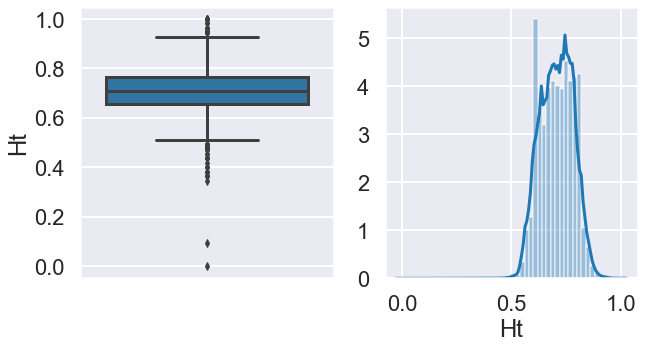

In [11]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'Ht', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['Ht'],  ax=axes[1])

## Weight

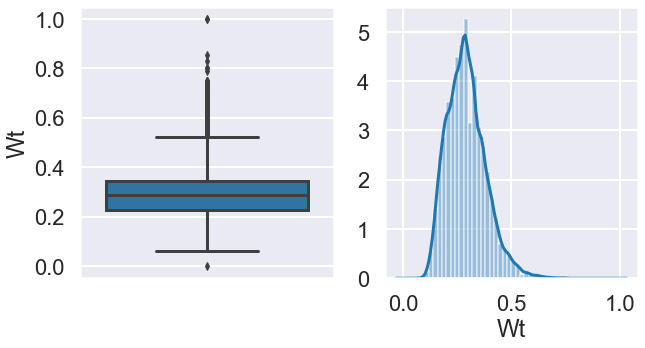

In [12]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'Wt', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['Wt'],  ax=axes[1])

# Converting the Multiclass problem into Binary classes problem

As discussed above, we will turn this Multiclass classification challenge into Binary classification challenge.

Unique values in Target Variable: int64
Unique values in Target Variable: [1 0]
Total Number of unique values : 2


Text(0.5, 1.0, 'Distribution of rows by response categories')

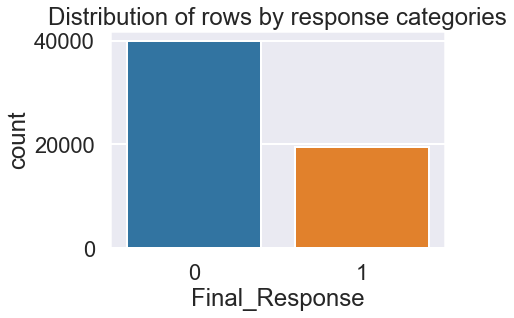

In [13]:
#create a funtion to create new target variable based on conditions
# 0 means reject
# 1 means accept

def new_target(row):
    if (row['Response']<=7):
        val=0
    elif (row['Response']==8):
        val=1
    else:
        val=2
    return val


#create a copy of original dataset
new_data = train.copy()

#create a new column
new_data['Final_Response'] = new_data.apply(new_target,axis=1)

#print unique values of target variable
print("Unique values in Target Variable: {}".format(new_data.Final_Response.dtype))
print("Unique values in Target Variable: {}".format(new_data.Final_Response.unique()))
print("Total Number of unique values : {}".format(len(new_data.Final_Response.unique())))

#distribution plot for target classes
sns.countplot(x = new_data.Final_Response).set_title('Distribution of rows by response categories')

In [14]:
new_data.drop(['Response'], axis=1, inplace=True)
train = new_data
del new_data
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,...,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Final_Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,...,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
train.rename(columns={'Final_Response': 'Response'}, inplace=True)

# Feature Engineering (Exploratory Data Analysis)

Insurance companies usually categorize or decide which policy is compatible with a potential applicant. As such, high risk applicants will not be able to get the default insurance policy (ie. the safest) which is reserved for applicants with 'safe' backgrounds. High risk factors that come into play when determining the insurance policy may include old age, obesity, high BMI, bodily deformations (dwarfism or gigantism), etc. 

Considering how the data we have is a combination of continuous and categorical variables, it would be wise to convert most of the continuous variables into categorical ones to simplify the problem at hand. This is done by categorizing the age, BMI, height, and weight:

1. Person very old or very young or in middle
2. Person very short or tall or in middle
3. Person with very high BMI or low BMI or in middle
4. Persons with obesity or are very thin or in middle

We will also create few more features such as:

1. Multiplication of BMI and Age - higher the factor, higher the risk
2. Multiplication of Weight and Age - higher the factor, higher the risk
3. Multiplication of Height and Age
4. Split of Product Info 2 into numericals and characters
5. Few stats description of Medical Keywords
6. Depending on the BMI, classification of lives into High Risk or Low Risk (very low and very high BMI both are risky factors)
7. Depending on BMI, Ht, Wt, Age, creation of more features which basically categorizes the risk into different buckets

In [16]:
#1. We seperate Product_Info_2 into two separate columns
train['Product_Info_2_char'] = train.Product_Info_2.str[0]
train['Product_Info_2_num'] = train.Product_Info_2.str[1]

train['Product_Info_2_char'] = pd.factorize(train['Product_Info_2_char'])[0]
train['Product_Info_2_num'] = pd.factorize(train['Product_Info_2_num'])[0]

In [17]:
#2. We get some combined features to see the weight of those relations
train['BMI_Age'] = train['BMI'] * train['Ins_Age']
train['Age_Wt'] = train['Ins_Age'] * train['Wt']
train['Age_Ht'] = train['Ins_Age'] * train['Ht']

In [18]:
#3. We summarize all the medical keyword columns
med_keyword_columns = train.columns[train.columns.str.startswith('Medical_Keyword_')]
train['Med_Keywords_Count'] = train[med_keyword_columns].sum(axis=1)

In [19]:
#4. We get the squares of the continuous variables
train['Ins_Age_sq'] = train['Ins_Age'] * train['Ins_Age']
train['Ht_sq'] = train['Ht'] * train['Ht']
train['Wt_sq'] = train['Wt'] * train['Wt']
train['BMI_sq'] = train['BMI'] * train['BMI']

### We now define the categorization of the continuous variables

In [20]:
# BMI Categorization
conditions = [
    (train['BMI'] <= train['BMI'].quantile(0.25)),
    (train['BMI'] > train['BMI'].quantile(0.25)) & (train['BMI'] <= train['BMI'].quantile(0.75)),
    (train['BMI'] > train['BMI'].quantile(0.75))]

#choices = ['under_weight', 'average', 'overweight']
choices = [-1, 0, 1]

# New column for the categorized variable
train['BMI_Wt'] = np.select(conditions, choices)

In [21]:
# Age Categorization
conditions = [
    (train['Ins_Age'] <= train['Ins_Age'].quantile(0.25)),
    (train['Ins_Age'] > train['Ins_Age'].quantile(0.25)) & (train['Ins_Age'] <= train['Ins_Age'].quantile(0.75)),
    (train['Ins_Age'] > train['Ins_Age'].quantile(0.75))]

#choices = ['young', 'average', 'old']
choices = [-1, 0, 1]

# New column for the categorized variable
train['Old_Young'] = np.select(conditions, choices)

In [22]:
# Height Categorization
conditions = [
    (train['Ht'] <= train['Ht'].quantile(0.25)),
    (train['Ht'] > train['Ht'].quantile(0.25)) & (train['Ht'] <= train['Ht'].quantile(0.75)),
    (train['Ht'] > train['Ht'].quantile(0.75))]

#choices = ['short', 'average', 'tall']
choices = [-1, 0, 1]

# New column for the categorized variable
train['Short_Tall'] = np.select(conditions, choices)

In [23]:
# Weight Categorization
conditions = [
    (train['Wt'] <= train['Wt'].quantile(0.25)),
    (train['Wt'] > train['Wt'].quantile(0.25)) & (train['Wt'] <= train['Wt'].quantile(0.75)),
    (train['Wt'] > train['Wt'].quantile(0.75))]

#choices = ['thin', 'average', 'fat']
choices = [-1, 0, 1]

# New column for the categorized variable
train['Thin_Fat'] = np.select(conditions, choices)

In [24]:

med_keyword_columns = train.columns[train.columns.str.startswith('Medical_Keyword_')]
train['Med_Keywords_Count'] = train[med_keyword_columns].sum(axis=1)

# Next, we will try to see the level of risk extremity of the applicants

## We will create new columns to see each of their corellation to the responses

In the first assumption, we assume that those applicants who are overweight, old, or fat are applicants who are considered very risky to offer insurance to.

In [25]:
def extreme_risk_analysis(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        #val='extremely_risky'
        val=1
    else:
        #val='not_extremely_risky'
        val=0
        
    return val

train['extreme_risk'] = train.apply(extreme_risk_analysis,axis=1)

In [26]:
train.extreme_risk.value_counts()

0    59381
Name: extreme_risk, dtype: int64

Logically, not all who are fat or thin or short or tall are actually risky. This is why we try to assume the BMI as a reference for the risks and thus policy of the applicants.

In [27]:
# BMI Risk Categorization
conditions = [
    (train['BMI_Wt'] == 'overweight') ,
    (train['BMI_Wt'] == 'average') ,
    (train['BMI_Wt'] == 'under_weight') ]

#choices = ['risk', 'non-risk', 'risk']
choices = [-1, 0, 1]

train['risk_bmi'] = np.select(conditions, choices)

In [28]:
train.risk_bmi.value_counts()

0    59381
Name: risk_bmi, dtype: int64

We assume that those who have an average in any of the categories also have average risks.

In [29]:
def averages(row):
    if (row['BMI_Wt']=='average') or (row['Old_Young']=='average')  or (row['Thin_Fat']=='average') or (row['Short_Tall']=='average'):
        #val='average'
        val=1
    else:
        #val='non_average'
        val=0
    return val

train['average_risk'] = train.apply(averages,axis=1)

In [30]:
train.average_risk.value_counts()

0    59381
Name: average_risk, dtype: int64

We will try to see how the low end risks compare to the responses.

In [31]:
def low_end(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin') or (row['Short_Tall']=='short'):
        #val='low_end'
        val=1
    else:
        #val='non_low_end'
        val=0
    return val

#29
train['low_end_risk'] = train.apply(low_end,axis=1)

In [32]:
train.low_end_risk.value_counts()

0    59381
Name: low_end_risk, dtype: int64

Finally we try to see the high end risks and its corellation.

In [33]:
def high_end(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat') or (row['Short_Tall']=='tall'):
        #val='high_end'
        val=1
    else:
        #val='non_high_end'
        val=0
    return val

#30
train['high_end_risk'] = train.apply(high_end,axis=1)

In [34]:
train.high_end_risk.value_counts()

0    59381
Name: high_end_risk, dtype: int64

# Now we will see if our assumptions bear weight

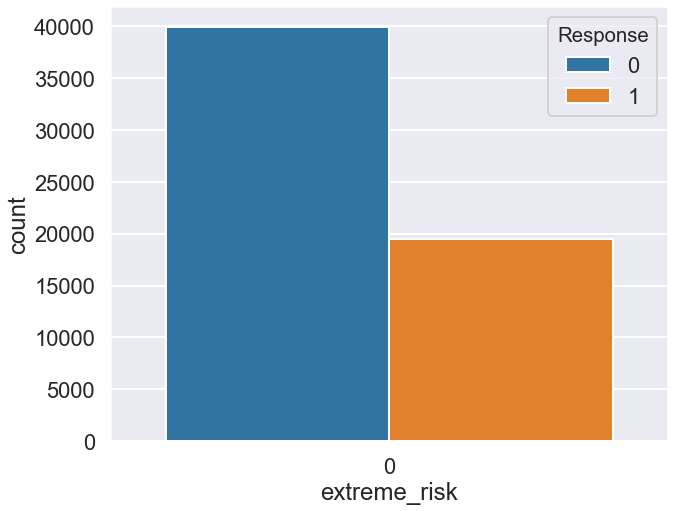

In [35]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'extreme_risk', hue = 'Response', data = train)

This category reveals that applicants marked with the label 'extremely risky' are less likely to receive the standard insurance policy.

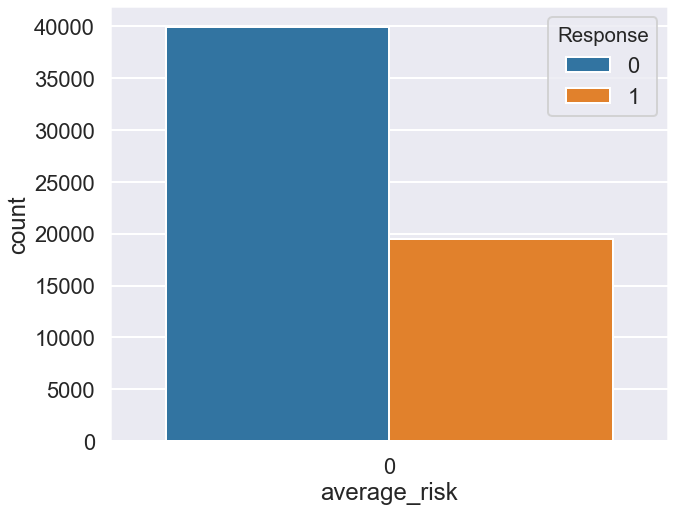

In [36]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'average_risk', hue = 'Response', data = train)

This category does not reveal any corellation with the responses since non-average risk applicants as a whole receive less policies than the average risk applicants.

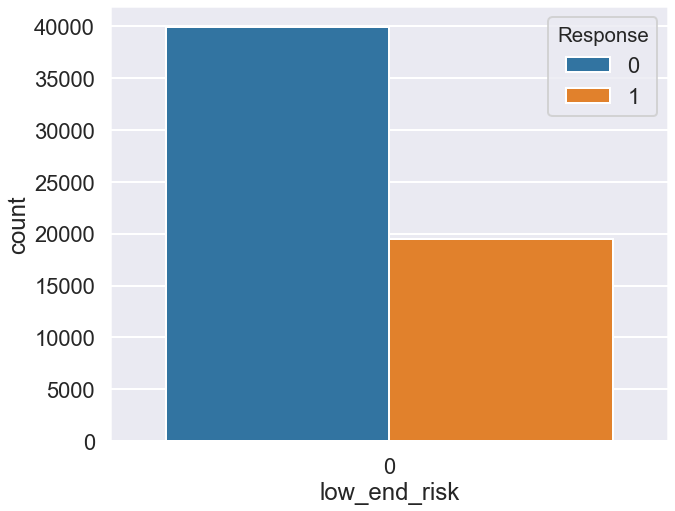

In [37]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'low_end_risk', hue = 'Response', data = train)

Applicants who aren't categorized as low risked are generally given sub-standard policies.

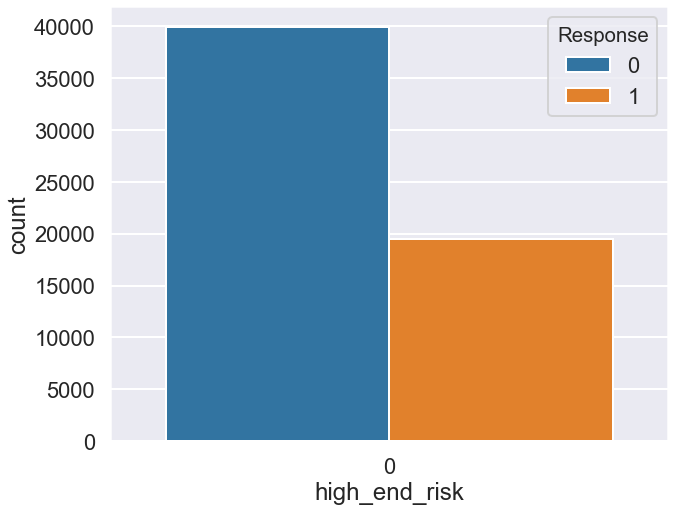

In [38]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'high_end_risk', hue = 'Response', data = train)

High end risk applicants are generally given sub-standard policies.

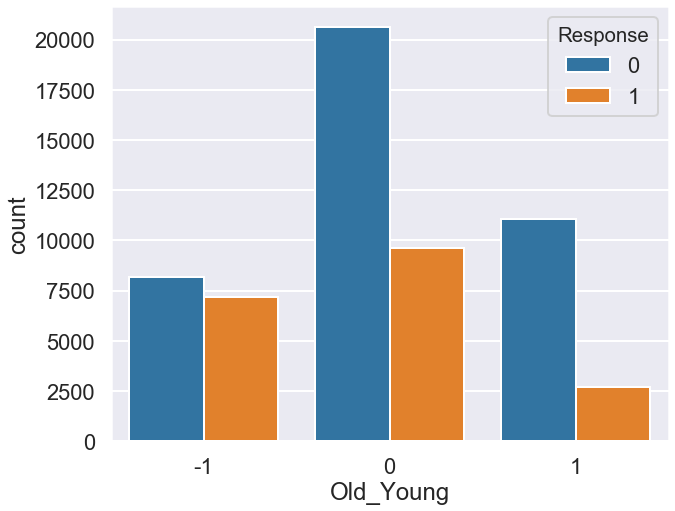

In [39]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'Old_Young', hue = 'Response', data = train)

From this category, it can be concluded that old applicants tend to not receive the standard insurance policy. This is actually logical since old-aged people tend to have higher risks in health.

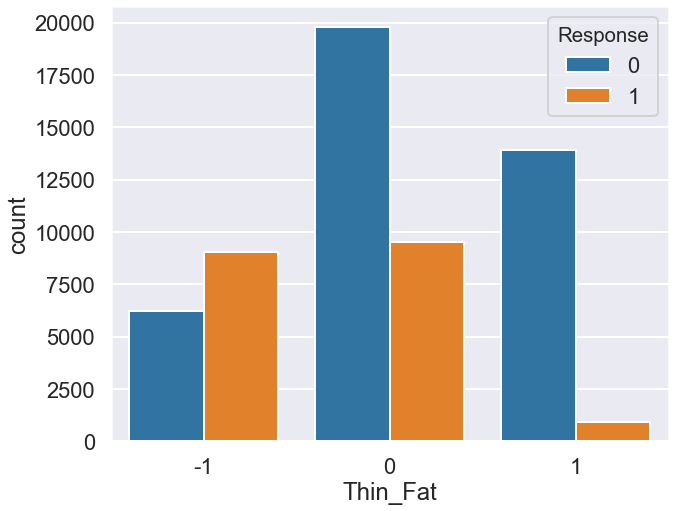

In [40]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'Thin_Fat', hue = 'Response', data = train)

This illustration reveals that fatter applicants are usually not given standard insurance policies, probably due to health concerns.

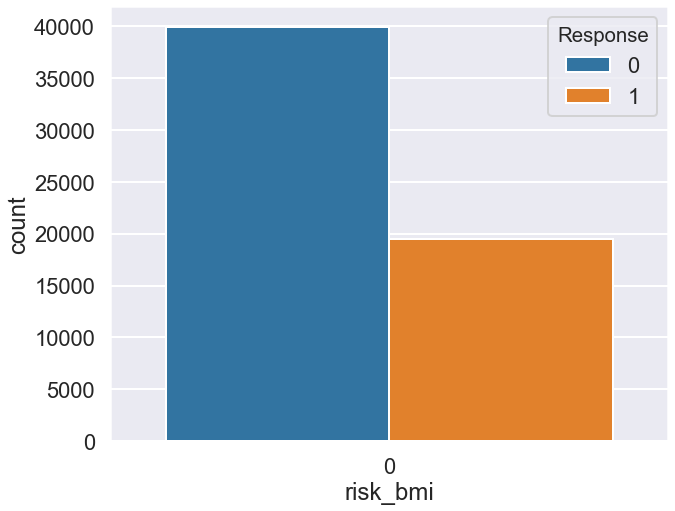

In [41]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'risk_bmi', hue = 'Response', data = train)

This category depicts how applicants with riskier BMI ratings tend to not be given standard insurance policies, though the difference between the two categories are not so different.

In [42]:
train.head(20)

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,...,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_char,Product_Info_2_num,BMI_Age,Age_Wt,Age_Ht,Med_Keywords_Count,Ins_Age_sq,Ht_sq,Wt_sq,BMI_sq,BMI_Wt,Old_Young,Short_Tall,Thin_Fat,extreme_risk,risk_bmi,average_risk,low_end_risk,high_end_risk
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.0280,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.207304,0.095329,0.373406,0,0.411896,0.338512,0.022063,0.104334,-1,1,-1,-1,0,0,0,0,0
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.0000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.016256,0.007869,0.035821,0,0.003564,0.360000,0.017371,0.074141,-1,-1,-1,-1,0,0,0,0,0
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.0300,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0.012799,0.008618,0.022252,0,0.000891,0.555702,0.083349,0.183853,0,-1,0,0,0,0,0,0,0
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.0420,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0.057863,0.033660,0.110448,1,0.026955,0.452562,0.042034,0.124212,-1,-1,0,-1,0,0,0,0,0
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.0270,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0.177213,0.097920,0.273541,0,0.174649,0.428430,0.054901,0.179815,0,0,-1,0,0,0,0,0,0
5,10,1,D2,26,0.230769,3,1,1,0.507463,0.836364,0.299163,0.364887,0.3250,15,1,0.0,2,1.0000,1,2,8,3,1,1,1,2,1,3,2,0.005000,1,3,2,2,NaN,0.294118,0.507042,NaN,6.0,491,2,2,1,3,2,2,2,NaN,3,2,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0.185166,0.151814,0.424423,2,0.257518,0.699504,0.089499,0.133142,-1,0,1,0,0,0,0,0,0
6,11,1,A8,10,0.166194,2,3,1,0.373134,0.581818,0.173640,0.376587,0.1100,1,3,NaN,3,0.8000,1,2,3,3,1,2,1,1,1,3,2,0.001667,1,1,2,3,0.594203,NaN,0.549296,NaN,5.0,600,3,2,1,3,2,2,1,NaN,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,0.140517,0.064791,0.217096,0,0.139229,0.338512,0.030151,0.141818,-1,0,-1,-1,0,0,0,0,0
7,14,1,D2,26,0.076923,2,3,1,0.611940,0.781818,0.403766,0.571612,0.1200,12,1,0.0,

## Excluding features to be used as new train datasets

In [43]:
exclude = ['Product_Info_1', 'Old_Young', 'Short_Tall', 'Thin_Fat', 'BMI_Wt', 'Employment_Info_2',
           'InsuredInfo_1', 'Family_Hist_1', 'Medical_History_3',  'Med_Keywords_Count',
           'Response']

In [44]:
new_train = train[exclude]

In [45]:
new_train.head()

,Product_Info_1,Old_Young,Short_Tall,Thin_Fat,BMI_Wt,Employment_Info_2,InsuredInfo_1,Family_Hist_1,Medical_History_3,Med_Keywords_Count,Response
0,1,1,-1,-1,-1,12,1,2,2,0,1
1,1,-1,-1,-1,-1,1,1,2,2,0,0
2,1,-1,0,0,0,9,1,3,2,0,1
3,1,-1,0,-1,-1,9,2,3,2,1,1
4,1,0,-1,0,0,9,1,2,2,0,1


In [46]:
new_train.BMI_Wt.unique()

array([-1,  0,  1], dtype=int64)

## Importing libraries for model

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import classification_report,recall_score,accuracy_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

seed = 0
dt=DecisionTreeClassifier(random_state=seed)
rf=RandomForestClassifier(random_state=seed)
svc=SVC(random_state=seed)

import pickle
pickle_file = "../pickle_file/"

In [48]:
X = new_train.drop('Response', axis=1)
Y = new_train['Response']

In [49]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20, random_state=100)

In [50]:
new_train['BMI_Wt'] = pd.factorize(new_train['BMI_Wt'])[0]

In [51]:
Xtrain.head()

,Product_Info_1,Old_Young,Short_Tall,Thin_Fat,BMI_Wt,Employment_Info_2,InsuredInfo_1,Family_Hist_1,Medical_History_3,Med_Keywords_Count
36686,1,0,0,0,0,12,2,2,2,2
1176,1,-1,0,0,0,14,1,3,2,2
12083,1,0,1,1,0,12,1,2,3,2
39999,1,0,-1,-1,0,9,1,3,2,1
10883,1,1,-1,-1,0,9,2,3,2,3


In [52]:
from sklearn.metrics import classification_report, confusion_matrix

# Random Forest

In [53]:
rf = RandomForestClassifier(max_depth=3, random_state=100)
rf.fit(Xtrain, Ytrain)
rf_train_pred = rf.predict(Xtrain)
rf_test_pred = rf.predict(Xtest)
pickle.dump(rf, open(pickle_file+'rf_model.pkl', 'wb'))

In [54]:
rf_train_accuracy = rf.score(Xtrain,Ytrain)
rf_test_accuracy = rf.score(Xtest,Ytest)
rf_accuracy = rf_train_accuracy*100
print("RF Train Accuracy: " + str(round(rf_train_accuracy*100,3)) + "%")
print("RF Test Accuracy: " + str(round(rf_test_accuracy*100,3)) + "%")

RF Train Accuracy: 73.263%
RF Test Accuracy: 72.678%


In [55]:
rf_pred = rf.predict(Xtest)
print(confusion_matrix(Ytest, rf_pred))
print(classification_report(Ytest, rf_pred))

[[7436  503]
 [2742 1196]]
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      7939
           1       0.70      0.30      0.42      3938

    accuracy                           0.73     11877
   macro avg       0.72      0.62      0.62     11877
weighted avg       0.72      0.73      0.69     11877



# Decision Tree

In [56]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth=3, random_state=100)
dt.fit(Xtrain, Ytrain)
dt_train_pred = dt.predict(Xtrain)
dt_test_pred = dt.predict(Xtest)
pickle.dump(dt, open(pickle_file+'dt_model.pkl', 'wb'))

In [57]:
dt_train_accuracy=dt.score(Xtrain,Ytrain)
dt_test_accuracy=dt.score(Xtest,Ytest)
dt_accuracy = dt_train_accuracy *100
print("Decision Tree Train Accuracy: " + str(round(dt_train_accuracy *100, 3)) + '%')
print("Decision Tree Test Accuracy: " + str(round(dt_test_accuracy *100, 3)) + '%')

Decision Tree Train Accuracy: 72.882%
Decision Tree Test Accuracy: 72.367%


In [60]:
dt_pred = dt.predict(Xtest)
print(confusion_matrix(Ytest, dt_pred))
print(classification_report(Ytest, dt_pred))

[[7516  423]
 [2859 1079]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      7939
           1       0.72      0.27      0.40      3938

    accuracy                           0.72     11877
   macro avg       0.72      0.61      0.61     11877
weighted avg       0.72      0.72      0.68     11877



# SVM

In [58]:
svc = SVC()
svc.fit(Xtrain, Ytrain)
svc_train_pred = svc.predict(Xtrain)
svc_test_pred = svc.predict(Xtest)
pickle.dump(svc, open(pickle_file+'svc_model.pkl', 'wb'))

In [59]:
svc_train_accuracy=svc.score(Xtrain,Ytrain)
svc_test_accuracy=svc.score(Xtest,Ytest)
svc_accuracy = svc_train_accuracy *100
print("SVM Train Accuracy: " + str(round(svc_train_accuracy *100, 3)) + '%')
print("SVM Test Accuracy: " + str(round(svc_test_accuracy *100, 3)) + '%')

SVM Train Accuracy: 74.975%
SVM Test Accuracy: 74.379%


In [61]:
svc_pred = svc.predict(Xtest)
print(confusion_matrix(Ytest, svc_pred))
print(classification_report(Ytest, svc_pred))

[[7050  889]
 [2154 1784]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      7939
           1       0.67      0.45      0.54      3938

    accuracy                           0.74     11877
   macro avg       0.72      0.67      0.68     11877
weighted avg       0.73      0.74      0.73     11877

